In [18]:
# Importation des différentes librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import learning_curve, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2, mutual_info_classif, RFECV, RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, balanced_accuracy_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from scipy.stats import ttest_ind
from statsmodels.tools import add_constant
from statsmodels.api import Logit
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import tree
from sklearn.neural_network import MLPClassifier

In [25]:
#on définit les datasets et la variable de prédiction
df = pd.read_csv('data_unscaled', index_col=0)
df_scaled = pd.read_csv('data_scaled', index_col=0)
prediction = 'high_blood_pressure'

#on importe la liste des variables binaires
co_binaires_bis = pd.read_csv('co_binaires_bis', index_col=0)
co_binaires_bis = co_binaires_bis.values.tolist()
co_binaires_bis = sum(co_binaires_bis, [])

## Feature Selection

In [21]:
# Définition du DataSet
X = df_scaled.drop(prediction, axis = 1)
y = df_scaled[prediction]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y)

### La variance

In [22]:
# Définition d'une fonction pour entraîner un modèle
def fit(X_train, X_test, y_train, y_test, co_continues, model):
    model = model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_predict)
    auc_model = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    proba = model.predict_proba(X_test)[:,1]

    return y_test, y_predict, accuracy, auc_model, proba, model

In [23]:
# Définition d'une fonction qui renvoie les meilleures features
def best_features(model, X_train, threshold) :     
    features_importances = []
    index_best_features = []
    list_results = model.feature_importances_.tolist()
    best_features = []
    for i in range(len(list_results)):
        if list_results[i] > threshold :
            index_best_features.append(i)
            features_importances.append(list_results[i])
            best_features.append(X_train.columns[i])
    return best_features, features_importances

In [26]:
# Définition du selector
selector = VarianceThreshold(threshold = 0.04)

selector.fit_transform(X)
features_select_var = list(np.array(list(X))[selector.get_support()])

X_train_var = X_train[features_select_var]
X_test_var = X_test[features_select_var]

co_binaires_var = []
co_continues_var = []
for co in features_select_var:
    if co in co_binaires_bis:
        co_binaires_var.append(co)
    else :
        co_continues_var.append(co)

Le balanced accuracy score pour le modèle RandomForest : 0.616
Pourcentage de bien classés pour le modèle RandomForest : 0.727
Aire sous la courbe ROC pour le modèle RandomForest : 0.793
La précision pour la réponse négative pour le modèle RandomForest :  0.75
La précision pour la réponse positive pour le modèle RandomForest :  0.61
Les meilleures features pour le modèle RandomForest sont :  ['order_to_reduce_salt', 'age\xa0', 'albumine', 'creatinine', 'cholesterol', 'blood_lead', 'blood_mercury', 'blood_selenium', 'blood_manganese', 'lymphocyte', 'monocyte', 'neutrophils', 'eosinophils', 'hemoglobin', 'hematocrit', 'platelet', 'ferritin', 'glycohemoglobin', 'vitamin_c']


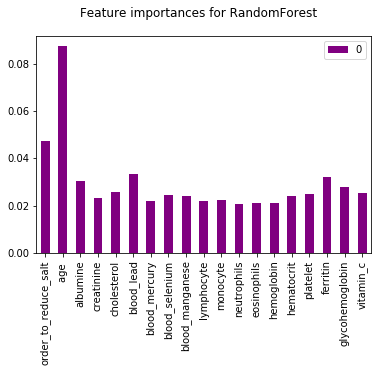

In [27]:
# Utilisation de la sélection avec le modèle RandomForest
y_test_rf_var, y_predict_rf_var, accuracy_rf_var, auc_model_rf_var, proba_rf_var, model_rf_var = fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, RandomForestClassifier())
precision_rf_var = precision_recall_fscore_support(y_test_rf_var,y_predict_rf_var)[0].round(2)
balanced_acc_rf_var = balanced_accuracy_score(y_test_rf_var,y_predict_rf_var)

print('Le balanced accuracy score pour le modèle RandomForest : {:.3g}'.format(balanced_acc_rf_var))
print('Pourcentage de bien classés pour le modèle RandomForest : {:.3g}' .format(accuracy_rf_var))
print("Aire sous la courbe ROC pour le modèle RandomForest : {:.3g}" .format(auc_model_rf_var))
print("La précision pour la réponse négative pour le modèle RandomForest : ", precision_rf_var[0])
print("La précision pour la réponse positive pour le modèle RandomForest : ", precision_rf_var[1])

model_rf_feat = RandomForestClassifier()
fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, model_rf_feat)
best_features_rf_var, features_importance_rf_var = best_features(model_rf_feat,X_train_var, 0.02)
print('Les meilleures features pour le modèle RandomForest sont : ', best_features_rf_var)

pd.DataFrame(features_importance_rf_var, index = best_features_rf_var).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest')
plt.legend()

Le balanced accuracy score pour le modèle DecisionTree : 0.687
Pourcentage de bien classés pour le modèle DecisionTree : 0.716
Aire sous la courbe ROC pour le modèle DecisionTree : 0.687
La précision pour la réponse négative pour le modèle DecisionTree :  0.81
La précision pour la réponse positive pour le modèle DecisionTree :  0.54
Les meilleures features pour le modèle DecisionTree sont :  ['order_to_reduce_salt', 'age\xa0', 'albumine', 'creatinine', 'blood_lead', 'blood_mercury', 'blood_manganese', 'basophils', 'hemoglobin', 'platelet', 'ferritin']


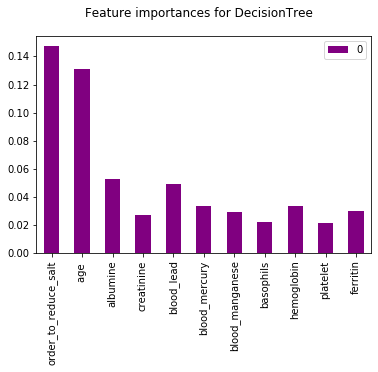

In [28]:
# Utilisation de la sélection avec le modèle DecisionTree
y_test_tree_var, y_predict_tree_var, accuracy_tree_var, auc_model_tree_var, proba_tree_var, model_tree_var = fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, DecisionTreeClassifier())
precision_tree_var = precision_recall_fscore_support(y_test_tree_var,y_predict_tree_var)[0].round(2)
balanced_acc_tree_var = balanced_accuracy_score(y_test_tree_var,y_predict_tree_var)

print('Le balanced accuracy score pour le modèle DecisionTree : {:.3g}'.format(balanced_acc_tree_var))
print('Pourcentage de bien classés pour le modèle DecisionTree : {:.3g}' .format(accuracy_tree_var))
print("Aire sous la courbe ROC pour le modèle DecisionTree : {:.3g}" .format(auc_model_tree_var))
print("La précision pour la réponse négative pour le modèle DecisionTree : ", precision_tree_var[0])
print("La précision pour la réponse positive pour le modèle DecisionTree : ", precision_tree_var[1])

model_tree_feat = DecisionTreeClassifier()
fit(X_train_var, X_test_var, y_train, y_test,co_continues_var, model_tree_feat)
best_features_tree_var, features_importance_tree_var = best_features(model_tree_feat,X_train_var, 0.02)
print('Les meilleures features pour le modèle DecisionTree sont : ', best_features_tree_var)

pd.DataFrame(features_importance_tree_var, index = best_features_tree_var).plot.bar(color = 'purple')
plt.suptitle('Feature importances for DecisionTree')
plt.legend()

In [29]:
# Utilisation de la sélection avec le modèle Knn
y_test_knn_var, y_predict_knn_var, accuracy_knn_var, auc_model_knn_var, proba_knn_var, model_knn_var = fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, KNeighborsClassifier())
precision_knn_var = precision_recall_fscore_support(y_test_knn_var,y_predict_knn_var)[0].round(2)
balanced_acc_knn_var = balanced_accuracy_score(y_test_knn_var,y_predict_knn_var)

print('Le balanced accuracy score pour le modèle kNN : {:.3g}'.format(balanced_acc_knn_var))
print('Pourcentage de bien classés pour le modèle kNN : {:.3g}' .format(accuracy_knn_var))
print("Aire sous la courbe ROC pour le modèle kNN : {:.3g}" .format(auc_model_knn_var))
print("La précision pour la réponse négative pour le modèle kNN : ", precision_knn_var[0])
print("La précision pour la réponse positive pour le modèle kNN : ", precision_knn_var[1])

Le balanced accuracy score pour le modèle kNN : 0.578
Pourcentage de bien classés pour le modèle kNN : 0.678
Aire sous la courbe ROC pour le modèle kNN : 0.678
La précision pour la réponse négative pour le modèle kNN :  0.73
La précision pour la réponse positive pour le modèle kNN :  0.47


In [30]:
# Utilisation de la sélection avec le modèle LogisticRegression
y_test_log_var, y_predict_log_var, accuracy_log_var, auc_model_log_var, proba_log_var, model_log_var = fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, LogisticRegression(max_iter=1000))
precision_log_var = precision_recall_fscore_support(y_test_log_var,y_predict_log_var)[0].round(2)
balanced_acc_log_var = balanced_accuracy_score(y_test_log_var,y_predict_log_var)

print('Le balanced accuracy score pour le modèle LogisticRegression : {:.3g}'.format(balanced_acc_log_var))
print('Pourcentage de bien classés pour le modèle LogisticRegression : {:.3g}' .format(accuracy_log_var))
print("Aire sous la courbe ROC pour le modèle LogisticRegression : {:.3g}" .format(auc_model_log_var))
print("La précision pour la réponse négative pour le modèle LogisticRegression : ", precision_log_var[0])
print("La précision pour la réponse positive pour le modèle LogisticRegression : ", precision_log_var[1])

Le balanced accuracy score pour le modèle LogisticRegression : 0.688
Pourcentage de bien classés pour le modèle LogisticRegression : 0.747
Aire sous la courbe ROC pour le modèle LogisticRegression : 0.789
La précision pour la réponse négative pour le modèle LogisticRegression :  0.8
La précision pour la réponse positive pour le modèle LogisticRegression :  0.6


In [31]:
# Utilisation de la sélection avec le modèle MLPClassifier
y_test_mlp_var, y_predict_mlp_var, accuracy_mlp_var, auc_model_mlp_var, proba_mlp_var, model_mlp_var = fit(X_train_var, X_test_var, y_train, y_test, co_continues_var, MLPClassifier(max_iter=1000))
precision_mlp_var = precision_recall_fscore_support(y_test_mlp_var,y_predict_mlp_var)[0].round(2)
balanced_acc_mlp_var = balanced_accuracy_score(y_test_mlp_var,y_predict_mlp_var)

print('Le balanced accuracy score pour le modèle MLPClassifier : {:.3g}'.format(balanced_acc_mlp_var))
print('Pourcentage de bien classés pour le modèle MLPClassifier : {:.3g}' .format(accuracy_mlp_var))
print("Aire sous la courbe ROC pour le modèle MLPClassifier : {:.3g}" .format(auc_model_mlp_var))
print("La précision pour la réponse négative pour le modèle MLPClassifier : ", precision_mlp_var[0])
print("La précision pour la réponse positive pour le modèle MLPClassifier : ", precision_mlp_var[1])

Le balanced accuracy score pour le modèle MLPClassifier : 0.639
Pourcentage de bien classés pour le modèle MLPClassifier : 0.711
Aire sous la courbe ROC pour le modèle MLPClassifier : 0.752
La précision pour la réponse négative pour le modèle MLPClassifier :  0.77
La précision pour la réponse positive pour le modèle MLPClassifier :  0.54


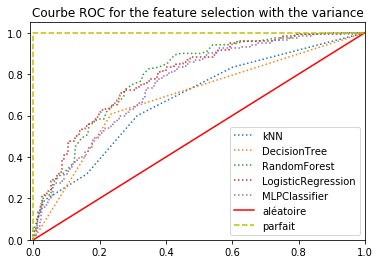

In [32]:
# Courbe ROC
# cas du modèle kNN
fpr, tpr, _ = roc_curve(y_test_knn_var, proba_knn_var)
plt.plot(fpr,tpr,":", label="kNN")

# cas du modèle DecisionTree
fpr, tpr, _ = roc_curve(y_test_tree_var, proba_tree_var)
plt.plot(fpr,tpr,":", label="DecisionTree")

# cas du modèle RandomForest
fpr, tpr, _ = roc_curve(y_test_rf_var, proba_rf_var)
plt.plot(fpr,tpr,":", label="RandomForest")

# cas du modèle LogisticRegression
fpr, tpr, _ = roc_curve(y_test_log_var, proba_log_var)
plt.plot(fpr,tpr,":", label="LogisticRegression")

# cas du modèle MLPClassifier
fpr, tpr, _ = roc_curve(y_test_mlp_var, proba_mlp_var)
plt.plot(fpr,tpr,":", label="MLPClassifier")

# modèle aléatoire
plt.plot([0, 1], [0, 1],"r-", label="aléatoire", )

# modèle parfait
plt.plot([0,0, 1], [0,1, 1], 'y--', label="parfait")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Courbe ROC for the feature selection with the variance')
plt.legend()

### RFE

C:\Users\pmong\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Optimal number of features : 2


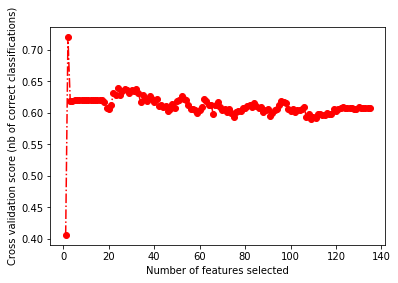

In [33]:
# Graphique donnant le score en fonction du nombre de features 
rfecv = RFECV(estimator=SVC(kernel="linear"), step=1, cv=2,
              scoring='precision')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 'or-.')
plt.show()

In [34]:
# Définition du selector
selector_rfe = RFE(SVC(kernel='linear'),step=1)
selector_rfe.fit(X_train,y_train)
features_select_rfe = list(np.array(list(X_train))[selector_rfe.get_support()])

In [35]:
# Définiton du nouveau dataset
co_binaires_rfe = []
co_continues_rfe = []
for co in features_select_rfe:
    if co in co_binaires_bis:
        co_binaires_rfe.append(co)
    else :
        co_continues_rfe.append(co)

X_train_rfe = X_train[features_select_rfe]
X_test_rfe = X_test[features_select_rfe]

Le balanced accuracy score pour le modèle RandomForest : 0.665
Pourcentage de bien classés pour le modèle RandomForest : 0.765
Aire sous la courbe ROC pour le modèle RandomForest : 0.816
La précision pour la réponse négative pour le modèle RandomForest :  0.78
La précision pour la réponse positive pour le modèle RandomForest :  0.72
Les meilleures features pour le modèle RandomForest sont :  ['arthritis', 'order_to_reduce_salt', 'high_cholesterol_level', 'albumine', 'basophils', 'hemoglobin', 'hematocrit', 'ferritin']


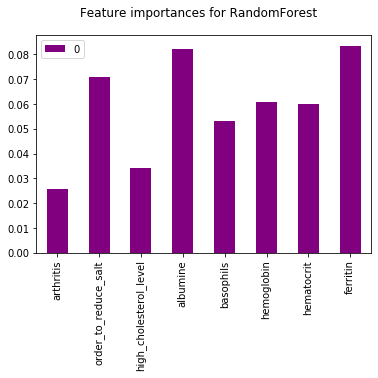

In [36]:
# Utilisation de la sélection avec le modèle RandomForest
y_test_rf_rfe, y_predict_rf_rfe, accuracy_rf_rfe, auc_model_rf_rfe, proba_rf_rfe, model_rf_rfe = fit(X_train_rfe, X_test_rfe, y_train, y_test, co_continues_rfe, RandomForestClassifier())
precision_rf_rfe = precision_recall_fscore_support(y_test_rf_rfe,y_predict_rf_rfe)[0].round(2)
balanced_acc_rf_rfe = balanced_accuracy_score(y_test_rf_rfe,y_predict_rf_rfe)

print('Le balanced accuracy score pour le modèle RandomForest : {:.3g}'.format(balanced_acc_rf_rfe))
print('Pourcentage de bien classés pour le modèle RandomForest : {:.3g}' .format(accuracy_rf_rfe))
print("Aire sous la courbe ROC pour le modèle RandomForest : {:.3g}" .format(auc_model_rf_rfe))
print("La précision pour la réponse négative pour le modèle RandomForest : ", precision_rf_rfe[0])
print("La précision pour la réponse positive pour le modèle RandomForest : ", precision_rf_rfe[1])

fit(X_train_rfe, X_test_rfe, y_train, y_test, co_continues_rfe, model_rf_feat)

best_features_rf_rfe, features_importance_rf_rfe = best_features(model_rf_feat,X_train_rfe, 0.02)
print('Les meilleures features pour le modèle RandomForest sont : ', best_features_rf_rfe)

pd.DataFrame(features_importance_rf_rfe, index = best_features_rf_rfe).plot.bar(color='purple')
plt.suptitle('Feature importances for RandomForest')
plt.legend()

Le balanced accuracy score pour le modèle DecisionTree : 0.625
Pourcentage de bien classés pour le modèle DecisionTree : 0.673
Aire sous la courbe ROC pour le modèle DecisionTree : 0.625
La précision pour la réponse négative pour le modèle DecisionTree :  0.77
La précision pour la réponse positive pour le modèle DecisionTree :  0.47
Les meilleures features pour le modèle DecisionTree sont :  ['order_to_reduce_salt', 'high_cholesterol_level', 'albumine', 'basophils', 'hemoglobin', 'hematocrit', 'ferritin', 'health_condition_4', 'marital_status_3', 'income_6']


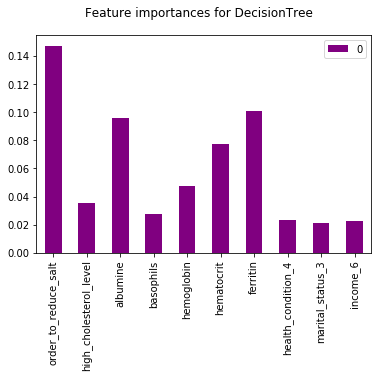

In [37]:
# Utilisation de la sélection avec le modèle DecisionTree
y_test_tree_rfe, y_predict_tree_rfe, accuracy_tree_rfe, auc_model_tree_rfe, proba_tree_rfe, model_tree_rfe = fit(X_train_rfe, X_test_rfe, y_train, y_test,co_continues_rfe, DecisionTreeClassifier())
precision_tree_rfe = precision_recall_fscore_support(y_test_tree_rfe,y_predict_tree_rfe)[0].round(2)
balanced_acc_tree_rfe = balanced_accuracy_score(y_test_tree_rfe,y_predict_tree_rfe)

print('Le balanced accuracy score pour le modèle DecisionTree : {:.3g}'.format(balanced_acc_tree_rfe))
print('Pourcentage de bien classés pour le modèle DecisionTree : {:.3g}' .format(accuracy_tree_rfe))
print("Aire sous la courbe ROC pour le modèle DecisionTree : {:.3g}" .format(auc_model_tree_rfe))
print("La précision pour la réponse négative pour le modèle DecisionTree : ", precision_tree_rfe[0])
print("La précision pour la réponse positive pour le modèle DecisionTree : ", precision_tree_rfe[1])

fit(X_train_rfe, X_test_rfe, y_train, y_test, co_continues_rfe, model_tree_feat)

best_features_tree_rfe, features_importance_tree_rfe = best_features(model_tree_feat,X_train_rfe, 0.02)
print('Les meilleures features pour le modèle DecisionTree sont : ', best_features_tree_rfe)

pd.DataFrame(features_importance_tree_rfe, index = best_features_tree_rfe).plot.bar(color = 'purple')
plt.suptitle('Feature importances for DecisionTree')
plt.legend()



In [38]:
# Utilisation de la sélection avec le modèle kNN
y_test_knn_rfe, y_predict_knn_rfe, accuracy_knn_rfe, auc_model_knn_rfe, proba_knn_rfe, model_knn_rfe = fit(X_train_rfe,X_test_rfe, y_train, y_test,co_continues_rfe, KNeighborsClassifier())
precision_knn_rfe = precision_recall_fscore_support(y_test_knn_rfe,y_predict_knn_rfe)[0].round(2)
balanced_acc_knn_rfe = balanced_accuracy_score(y_test_knn_rfe,y_predict_knn_rfe)

print('Le balanced accuracy score pour le modèle kNN : {:.3g}'.format(balanced_acc_knn_rfe))
print('Pourcentage de bien classés pour le modèle kNN : {:.3g}' .format(accuracy_knn_rfe))
print("Aire sous la courbe ROC pour le modèle kNN : {:.3g}" .format(auc_model_knn_rfe))
print("La précision pour la réponse négative pour le modèle kNN : ", precision_knn_rfe[0])
print("La précision pour la réponse positive pour le modèle kNN : ", precision_knn_rfe[1])

Le balanced accuracy score pour le modèle kNN : 0.578
Pourcentage de bien classés pour le modèle kNN : 0.719
Aire sous la courbe ROC pour le modèle kNN : 0.69
La précision pour la réponse négative pour le modèle kNN :  0.73
La précision pour la réponse positive pour le modèle kNN :  0.64


In [39]:
# Utilisation de la sélection avec le modèle LogisticRegression
y_test_log_rfe, y_predict_log_rfe, accuracy_log_rfe, auc_model_log_rfe, proba_log_rfe, model_log_rfe = fit(X_train_rfe, X_test_rfe, y_train, y_test, co_continues_rfe, LogisticRegression())
precision_log_rfe = precision_recall_fscore_support(y_test_log_rfe,y_predict_log_rfe)[0].round(2)
balanced_acc_log_rfe = balanced_accuracy_score(y_test_log_rfe,y_predict_log_rfe)

print('Le balanced accuracy score pour le modèle LogisticRegression : {:.3g}'.format(balanced_acc_log_rfe))
print('Pourcentage de bien classés pour le modèle LogisticRegression : {:.3g}' .format(accuracy_log_rfe))
print("Aire sous la courbe ROC pour le modèle LogisticRegression : {:.3g}" .format(auc_model_log_rfe))
print("La précision pour la réponse négative pour le modèle LogisticRegression : ", precision_log_rfe[0])
print("La précision pour la réponse positive pour le modèle LogisticRegression : ", precision_log_rfe[1])

Le balanced accuracy score pour le modèle LogisticRegression : 0.665
Pourcentage de bien classés pour le modèle LogisticRegression : 0.747
Aire sous la courbe ROC pour le modèle LogisticRegression : 0.773
La précision pour la réponse négative pour le modèle LogisticRegression :  0.78
La précision pour la réponse positive pour le modèle LogisticRegression :  0.63


In [40]:
# Utilisation de la sélection avec le modèle MLPClassifier
y_test_mlp_rfe, y_predict_mlp_rfe, accuracy_mlp_rfe, auc_model_mlp_rfe, proba_mlp_rfe, model_mlp_rfe = fit(X_train_rfe, X_test_rfe, y_train, y_test, co_continues_rfe, MLPClassifier())
precision_mlp_rfe = precision_recall_fscore_support(y_test_mlp_rfe,y_predict_mlp_rfe)[0].round(2)
balanced_acc_mlp_rfe = balanced_accuracy_score(y_test_mlp_rfe,y_predict_mlp_rfe)

print('Le balanced accuracy score pour le modèle MLPClassifier : {:.3g}'.format(balanced_acc_mlp_rfe))
print('Pourcentage de bien classés pour le modèle MLPClassifier : {:.3g}' .format(accuracy_mlp_rfe))
print("Aire sous la courbe ROC pour le modèle MLPClassifier : {:.3g}" .format(auc_model_mlp_rfe))
print("La précision pour la réponse négative pour le modèle MLPClassifier : ", precision_mlp_rfe[0])
print("La précision pour la réponse positive pour le modèle MLPClassifier : ", precision_mlp_rfe[1])

Le balanced accuracy score pour le modèle MLPClassifier : 0.678
Pourcentage de bien classés pour le modèle MLPClassifier : 0.74
Aire sous la courbe ROC pour le modèle MLPClassifier : 0.755
La précision pour la réponse négative pour le modèle MLPClassifier :  0.8
La précision pour la réponse positive pour le modèle MLPClassifier :  0.59


C:\Users\pmong\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


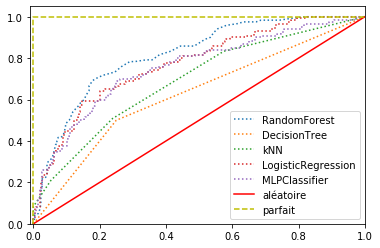

In [41]:
# Courbe ROC
# cas du modèle RandomForest
fpr, tpr, _ = roc_curve(y_test_rf_rfe, proba_rf_rfe)
plt.plot(fpr,tpr,":", label="RandomForest")

# cas du modèle DecisionTree
fpr, tpr, _ = roc_curve(y_test_tree_rfe, proba_tree_rfe)
plt.plot(fpr,tpr,":", label="DecisionTree")

# cas du modèle kNN
fpr, tpr, _ = roc_curve(y_test_knn_rfe, proba_knn_rfe)
plt.plot(fpr,tpr,":", label="kNN")

# cas du modèle LogisticRegression
fpr, tpr, _ = roc_curve(y_test_log_rfe, proba_log_rfe)
plt.plot(fpr,tpr,":", label="LogisticRegression")

# cas du modèle MLPClassifier
fpr, tpr, _ = roc_curve(y_test_mlp_rfe, proba_mlp_rfe)
plt.plot(fpr,tpr,":", label="MLPClassifier")

# modèle aléatoire
plt.plot([0, 1], [0, 1],"r-", label="aléatoire", )

# modèle parfait
plt.plot([0,0, 1], [0,1, 1], 'y--', label="parfait")

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()

### Graphique montrant les différentes sélections pour chaque modèle


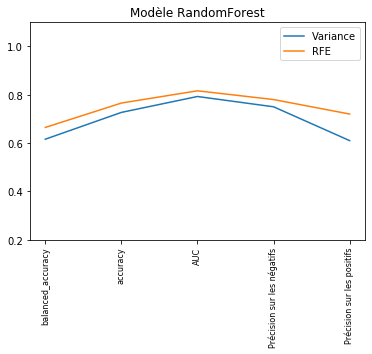

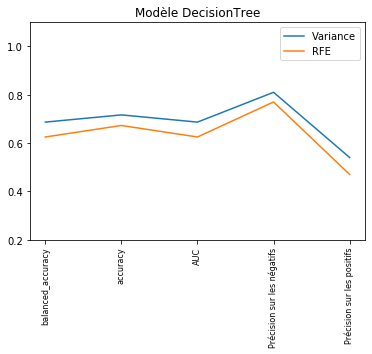

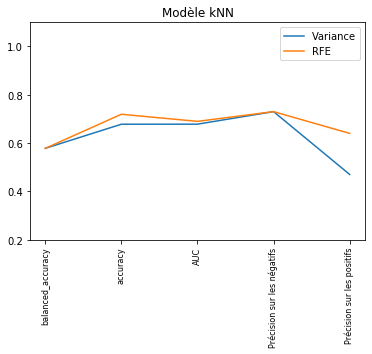

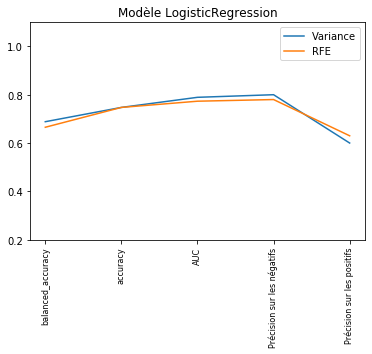

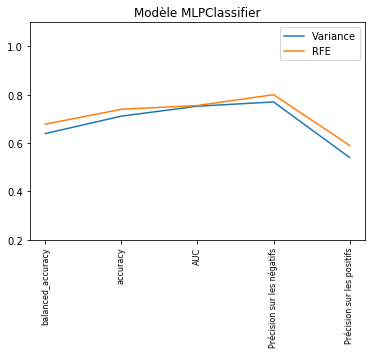

In [42]:
# Graphiques de résumé
X = ['balanced_accuracy', 'accuracy', 'AUC', 'Précision sur les négatifs', 'Précision sur les positifs']
Y_knn_var = [balanced_acc_knn_var, accuracy_knn_var, auc_model_knn_var, precision_knn_var[0], precision_knn_var[1]]
Y_knn_rfe = [balanced_acc_knn_rfe, accuracy_knn_rfe, auc_model_knn_rfe, precision_knn_rfe[0], precision_knn_rfe[1]]

Y_rf_var = [balanced_acc_rf_var, accuracy_rf_var, auc_model_rf_var, precision_rf_var[0], precision_rf_var[1]]
Y_rf_rfe = [balanced_acc_rf_rfe, accuracy_rf_rfe, auc_model_rf_rfe, precision_rf_rfe[0], precision_rf_rfe[1]]

Y_tree_var = [balanced_acc_tree_var, accuracy_tree_var, auc_model_tree_var, precision_tree_var[0], precision_tree_var[1]]
Y_tree_rfe = [balanced_acc_tree_rfe, accuracy_tree_rfe, auc_model_tree_rfe, precision_tree_rfe[0], precision_tree_rfe[1]]

Y_log_var = [balanced_acc_log_var, accuracy_log_var, auc_model_log_var, precision_log_var[0], precision_log_var[1]]
Y_log_rfe = [balanced_acc_log_rfe, accuracy_log_rfe, auc_model_log_rfe, precision_log_rfe[0], precision_log_rfe[1]]

Y_mlp_var = [balanced_acc_mlp_var, accuracy_mlp_var, auc_model_mlp_var, precision_mlp_var[0], precision_mlp_var[1]]
Y_mlp_rfe = [balanced_acc_mlp_rfe, accuracy_mlp_rfe, auc_model_mlp_rfe, precision_mlp_rfe[0], precision_mlp_rfe[1]]

plt.plot(X,Y_rf_var, label='Variance')
plt.plot(X,Y_rf_rfe, label='RFE')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 8, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle RandomForest')
plt.legend()
plt.show()

plt.plot(X,Y_tree_var, label='Variance')
plt.plot(X,Y_tree_rfe, label='RFE')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 8, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle DecisionTree')
plt.legend()
plt.show()

plt.plot(X,Y_knn_var, label='Variance')
plt.plot(X,Y_knn_rfe, label='RFE')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 8, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle kNN')
plt.legend()
plt.show()

plt.plot(X,Y_log_var, label='Variance')
plt.plot(X,Y_log_rfe, label='RFE')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 8, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle LogisticRegression')
plt.legend()
plt.show()

plt.plot(X,Y_mlp_var, label='Variance')
plt.plot(X,Y_mlp_rfe, label='RFE')
plt.gca().get_xaxis().set_ticklabels(X, fontsize = 8, rotation = 90)
plt.ylim(0.2,1.1)
plt.title('Modèle MLPClassifier')
plt.legend()
plt.show()

## Model Selection

In [194]:
# Définiton des dictionnaires des hyperparamètres
dico_param_tree = {'polynomialfeatures__degree':[2,3,4],
         'decisiontreeclassifier__criterion':['gini','entropy'],
         'decisiontreeclassifier__splitter' : ['best', 'random']}
dico_param_rf={'polynomialfeatures__degree':[2,3,4],
               "randomforestclassifier__n_estimators":[10,20,30,40,50],
               "randomforestclassifier__max_depth":[5, 6, 7,8,9,10],
              "randomforestclassifier__criterion":['gini','entropy'],
              "randomforestclassifier__max_features":['auto', 'sqrt', 'log2'],
              "randomforestclassifier__random_state":[None, 0, 42],
              "randomforestclassifier__class_weight" :[None, 'balanced']}
dico_param_knn={'polynomialfeatures__degree':[2,3,4],
                "kneighborsclassifier__n_neighbors":[2, 5, 10,15,18],
                "kneighborsclassifier__weights":['uniform','distance'],
               "kneighborsclassifier__algorithm" :['auto', 'ball_tree', 'kd_tree', 'brute']}
dico_param_log = {'polynomialfeatures__degree':[2,3,4], 
                 'logisticregression__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
                 'logisticregression__multi_class' : ['auto', 'ovr'], 
                 'logisticregression__max_iter': [10000]}
dico_param_mlp = {'polynomialfeatures__degree':[2,3,4],
                  'mlpclassifier__activation' : ['identity', 'logistic', 'tanh', 'relu'], 
                 'mlpclassifier__solver' : ['sgd', 'adam'],
                 'mlpclassifier__max_iter' : [1000]}


model_rf = make_pipeline(PolynomialFeatures(), RandomForestClassifier())
model_tree = make_pipeline(PolynomialFeatures(), DecisionTreeClassifier())
model_knn = make_pipeline(PolynomialFeatures(), KNeighborsClassifier())
model_log = make_pipeline(PolynomialFeatures(), LogisticRegression())
model_mlp = make_pipeline(PolynomialFeatures(), MLPClassifier())

In [195]:
# Définition d'une fonction donnant les meilleurs paramètres
def best_param(X_train, X_test, y_train, y_test,model, dico_param, cv_nb, co_continues):
    grid = GridSearchCV(model,param_grid = dico_param, cv=cv_nb)
    grid.fit(X_train, y_train)
    score = grid.score(X_test,y_test)
    return score, grid.best_params_

### Recherche des meilleurs paramètres

In [ ]:
# Recherche des meilleurs paramètres pour RandomForest
score_rf, best_params_rf = best_param(X_train, X_test, y_train, y_test, model_rf, dico_param_rf, 2, co_continues)

print('Pourcentage de bien classés pour le modèle RandomForest : {:.3g}' .format(score_rf))
print('Les meilleurs paramètres sont :', best_params_rf )

In [ ]:
# Recherche des meilleurs paramètres pour DecisionTree
score_tree, best_params_tree = best_param(X_train, X_test, y_train, y_test, model_tree, dico_param_tree, 2, co_continues)

print('Pourcentage de bien classés pour le modèle DecisionTree : {:.3g}' .format(score_tree))
print('Les meilleurs paramètres sont :', best_params_tree)

In [ ]:
# Recherche des meilleurs paramètres pour kNN
score_knn, best_params_knn = best_param(X_train, X_test, y_train, y_test, model_knn, dico_param_knn, 2, MaxAbsScaler(), co_continues)

print('Pourcentage de bien classés pour le modèle kNN : {:.3g}' .format(score_knn))
print('Les meilleurs paramètres sont :', best_params_knn)

In [ ]:
# Recherche des meilleurs paramètres pour LogisticRegression
score_log, best_params_log = best_param(X_train, X_test, y_train, y_test, model_log, dico_param_log, 2, MaxAbsScaler(), co_continues)

print('Pourcentage de bien classés pour le modèle LogisticRegression : {:.3g}' .format(score_log))
print('Les meilleurs paramètres sont :', best_params_log)

In [ ]:
# Recherche des meilleurs paramètres pour MLPClassifier
score_mlp, best_params_mlp = best_param(X_train, X_test, y_train, y_test, model_mlp, dico_param_mlp, 2, MinMaxScaler(), co_continues)

print('Pourcentage de bien classés pour le modèle MLPClassifier : {:.3g}' .format(score_mlp))
print('Les meilleurs paramètres sont :', best_params_mlp)

### Définition des modèles

In [ ]:
# Définition des modèles
model_rf = make_pipeline(PolynomialFeatures(degree=2), RandomForestClassifier(class_weight='balanced', criterion= 'gini', max_depth=10, max_features= 'log2', n_estimators=10, random_state=None))
model_tree = make_pipeline(PolynomialFeatures(degree=2), DecisionTreeClassifier(criterion='gini',splitter = 'random'))
model_knn = make_pipeline(PolynomialFeatures(degree=3), KNeighborsClassifier(algorithm = 'auto', n_neighbors = 15, weights='distance'))
model_log = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(solver = 'newton-cg', multi_class = 'auto', max_iter = 10000))
model_mlp = make_pipeline(PolynomialFeatures(degree=2), MLPClassifier(activation = 'relu', solver = 'adam', max_iter = 2000))